In [55]:
import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw
import os
%cd "/notebooks/yolov3keras/keras-yolo3"
from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
%cd /notebooks/cvzone

from keras.utils import multi_gpu_model

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model
import cv2
def get_iou(pred_box, gt_box):
    """
    pred_box : the coordinate for predict bounding box
    gt_box :   the coordinate for ground truth bounding box
    return :   the iou score
    the  left-down coordinate of  pred_box:(pred_box[0], pred_box[1])
    the  right-up coordinate of  pred_box:(pred_box[2], pred_box[3])
    """
    # 1.get the coordinate of inters
    ixmin = max(pred_box[0], gt_box[0])
    ixmax = min(pred_box[2], gt_box[2])
    iymin = max(pred_box[1], gt_box[1])
    iymax = min(pred_box[3], gt_box[3])

    iw = np.maximum(ixmax-ixmin+1., 0.)
    ih = np.maximum(iymax-iymin+1., 0.)

    # 2. calculate the area of inters
    inters = iw*ih

    # 3. calculate the area of union
    uni = ((pred_box[2]-pred_box[0]+1.) * (pred_box[3]-pred_box[1]+1.) +
           (gt_box[2] - gt_box[0] + 1.) * (gt_box[3] - gt_box[1] + 1.) -
           inters)

    # 4. calculate the overlaps between pred_box and gt_box
    iou = inters / uni

    return iou


class Recognizer:
    def __init__(self,threshold):
        self.prev_boxes=[]
        self.prev_outputs=[]
        self.threshold=threshold
    def recognize(self,boxes):
        output=list()
        if len(self.prev_boxes)>0:
            for bo in boxes:
                i=0
                done=False
                for box in self.prev_boxes:
                
                    IoU=get_iou(bo,box)
                    if IoU>self.threshold:
                        print('d')
                        output.append(self.prev_outputs[i])
                        done=True
                        break
                
                    i+=1
                if done==False:
                    output.append(max(self.prev_outputs)+1+len(output))
                    
        else:
            output=list(range(len(boxes)))
        self.prev_boxes,self.prev_outputs=boxes,output
        return output
                        
                    
class YOLO(object):
    _defaults = {
        "model_path": 'model.h5',
        "anchors_path": 'anchors.txt',
        "classes_path": 'classes.txt',
        "score" : 0.25,
        "iou" : 0.1,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.recognizer=Recognizer(0.2)
    
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype('LandasansMedium-ALJ6m.otf', size=100)
        thickness = (image.size[0] + image.size[1]) // 300
        no_of_cars=0
        out_classes=self.recognizer.recognize(out_boxes)
        self.out_classes=out_classes
        self.out_boxes=out_boxes
        self.out_scores=out_scores
        for i, c in reversed(list(enumerate(out_classes))):
          
            box = out_boxes[i]
            score = out_scores[i]

            label = str(c)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            no_of_cars+=1
            for i in range(thickness):
                
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline='red')
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill='red')
            
            draw.text(tuple(list(text_origin)), label, fill='black', font=font)
            del draw

        end = timer()
        print(end - start)
        return image,no_of_cars

     
       
    def close_session(self):
        self.sess.close()

def detect_video(yolo, vid, output_path=""):
   
    
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
    i=0
   
    while True:
        return_value, frame = vid.read()
        

      
        
        try:
           image = Image.fromarray(frame)
           image ,cars= yolo.detect_image(image)
        except:
            break
        
        
        
        result = np.asarray(image)
        curr_time = timer()
        exec_time = curr_time - prev_time
        prev_time = curr_time
        accum_time = accum_time + exec_time
        curr_fps = curr_fps + 1
        if accum_time > 1:
            accum_time = accum_time - 1
            fps = "FPS: " + str(curr_fps)
            curr_fps = 0
     
        cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=2)
        cv2.putText(result, text=str(cars), org=(1750,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=3)
        cv2.putText(result, text='Sayantan Mazumdar', org=(1000,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=3)
        
       
        #cv2.namedWindow("result", cv2.WINDOW_NORMAL)
       
          
        out.write(result)
        i+=1
      
        
    #yolo.close_session()

/notebooks/yolov3keras/keras-yolo3
/notebooks/cvzone


In [56]:
yolo=YOLO()

model.h5 model, anchors, and classes loaded.


In [57]:

img=Image.open('img.jpg')
r_image=yolo.detect_image(img)


(416, 416, 3)
Found 20 boxes for img
19 (791, 1007) (964, 1058)
18 (35, 299) (127, 434)
17 (977, 285) (1071, 450)
16 (1775, 298) (1890, 431)
15 (1455, 571) (1582, 787)
14 (158, 283) (255, 457)
13 (1297, 242) (1385, 485)
12 (1462, 219) (1545, 512)
11 (1, 454) (83, 861)
10 (1154, 235) (1221, 485)
9 (1800, 622) (1867, 724)
8 (1633, 241) (1719, 490)
7 (813, 296) (905, 442)
6 (1291, 602) (1388, 742)
5 (1615, 602) (1720, 756)
4 (477, 591) (569, 755)
3 (319, 573) (396, 738)
2 (485, 295) (559, 427)
1 (156, 599) (235, 731)
0 (632, 304) (730, 443)
4.254033873032313


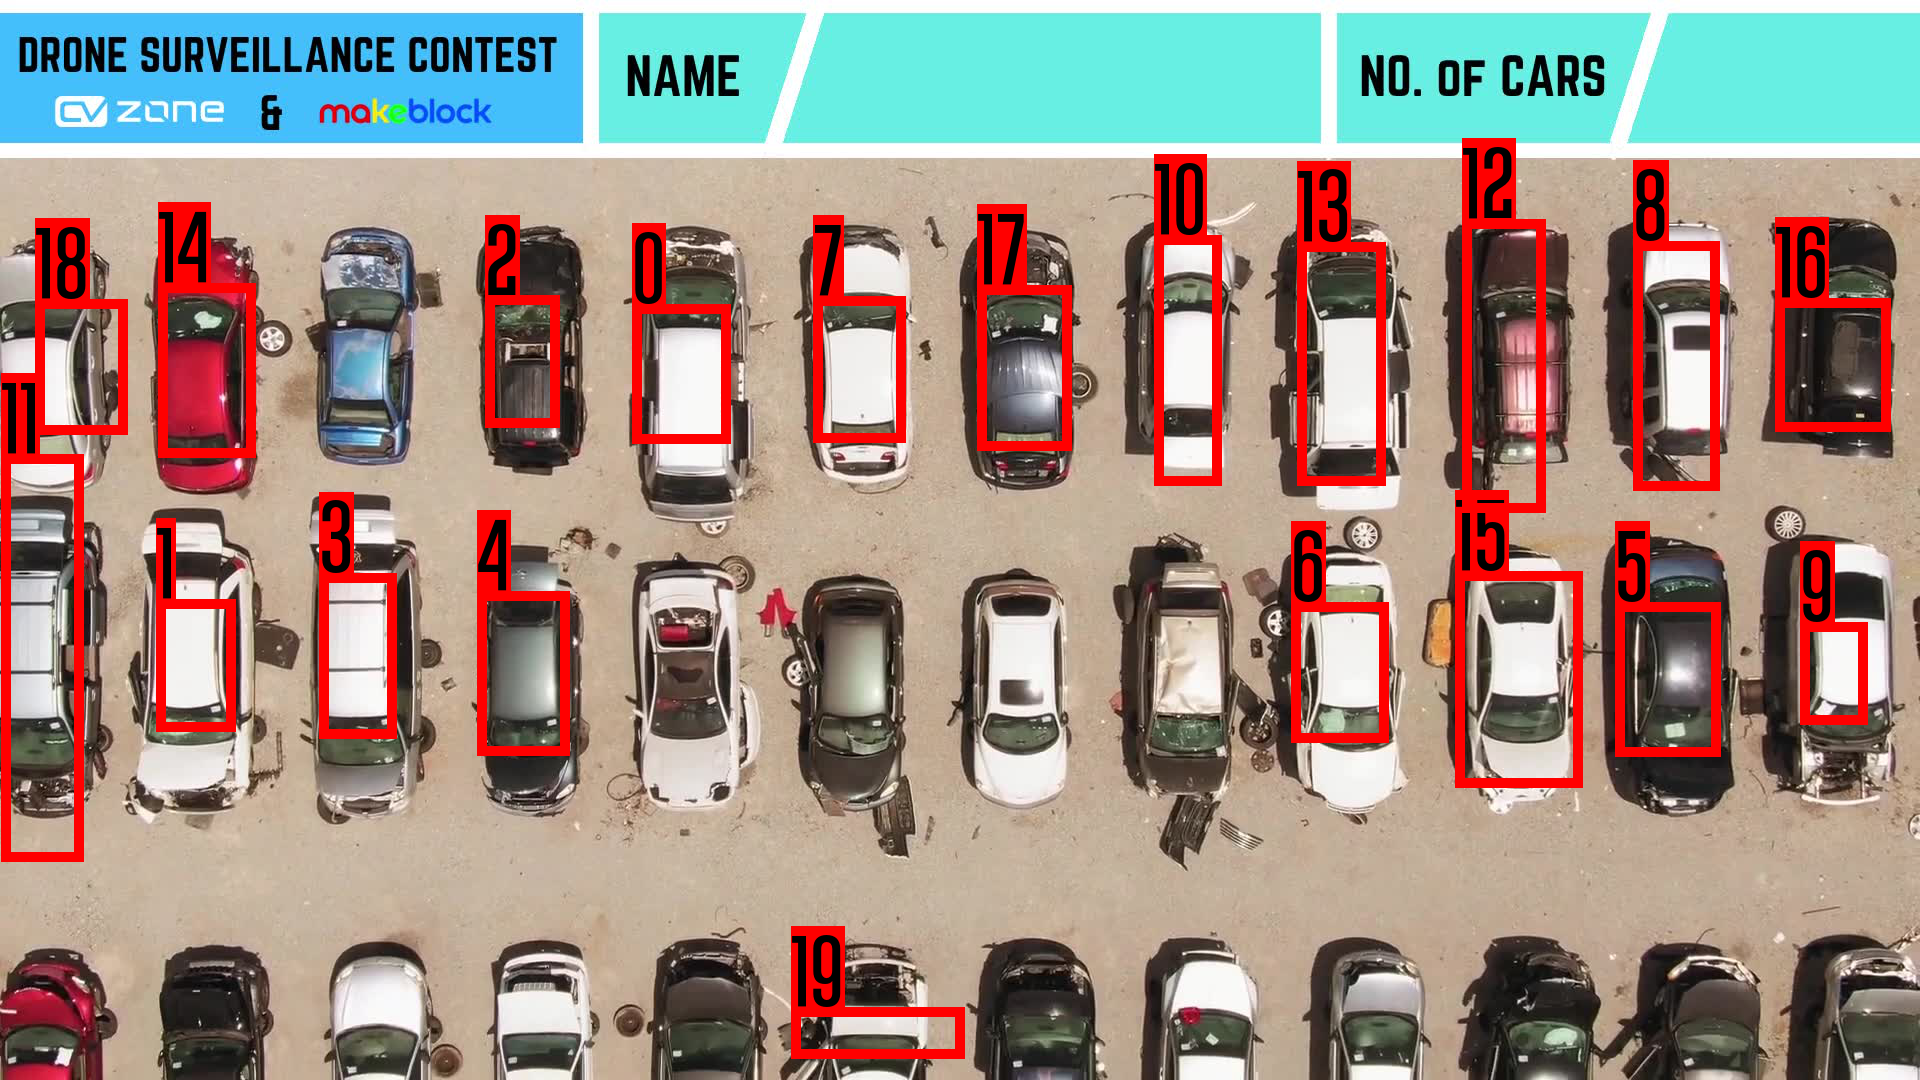

In [58]:
r_image[0]

In [59]:
vid=cv2.VideoCapture(r'/notebooks/cvzone/DRONE-SURVEILLANCE-CONTEST-VIDEO.avi')

In [60]:
vid.read()[1]

array([[[246, 254, 253],
        [246, 254, 253],
        [246, 254, 253],
        ...,
        [255, 252, 253],
        [255, 252, 253],
        [255, 252, 253]],

       [[246, 254, 253],
        [246, 254, 253],
        [246, 254, 253],
        ...,
        [255, 252, 253],
        [255, 252, 253],
        [255, 252, 253]],

       [[255, 252, 253],
        [255, 252, 253],
        [255, 252, 253],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       ...,

       [[ 45,  34,  93],
        [ 42,  31,  90],
        [ 38,  26,  90],
        ...,
        [ 60,  75,  73],
        [ 60,  75,  73],
        [ 60,  75,  73]],

       [[ 45,  36,  90],
        [ 42,  33,  87],
        [ 38,  27,  86],
        ...,
        [ 60,  75,  73],
        [ 60,  75,  73],
        [ 60,  75,  73]],

       [[ 45,  36,  90],
        [ 42,  33,  87],
        [ 38,  27,  86],
        ...,
        [ 60,  75,  73],
        [ 60,  75,  73],
        [ 60,  75,  73]]

In [61]:
detect_video(yolo,vid,'output.avi')

!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>
(416, 416, 3)
Found 20 boxes for img
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
18 (0, 287) (136, 569)
8 (1631, 275) (1725, 499)
11 (3, 520) (86, 914)
15 (1472, 613) (1579, 856)
10 (1155, 277) (1226, 547)
17 (974, 303) (1068, 535)
3 (314, 552) (402, 812)
2 (482, 306) (565, 497)
31 (954, 687) (1098, 796)
13 (1305, 308) (1384, 526)
1 (145, 620) (250, 816)
7 (819, 268) (915, 564)
27 (1137, 677) (1240, 801)
26 (624, 654) (742, 827)
14 (158, 347) (255, 494)
6 (1298, 628) (1395, 814)
0 (642, 309) (731, 518)
9 (1782, 646) (1889, 793)
4 (489, 586) (556, 857)
5 (1620, 652) (1734, 813)
0.13135936099570245
(416, 416, 3)
Found 20 boxes for img
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
15 (1470, 583) (1578, 875)
50 (1792, 266) (1878, 493)
17 (970, 284) (1073, 543)
18 (0, 282) (145, 567)
11 (6, 484) (84, 940)
27 (1135, 654) (1240, 796)
13 (1304, 294) (1383, 527)
6 (1295, 586) (1394, 842)
2 (477, 332) (563, 445)
10 (1144, 269) (1225, 498)
7 (81

In [62]:
import moviepy.editor as moviepy
clip = moviepy.VideoFileClip("output.avi")

clip.write_videofile("output.mp4")

t:   0%|          | 0/682 [00:00<?, ?it/s, now=None]

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4




t:  11%|█         | 76/682 [04:08<00:20, 30.27it/s, now=None] 

Moviepy - Done !
Moviepy - video ready output.mp4


In [64]:
from IPython.display import Video

Video("output.mp4")

In [8]:


import os, ffmpeg
def compress_video(video_full_path, output_file_name, target_size):
    # Reference: https://en.wikipedia.org/wiki/Bit_rate#Encoding_bit_rate
    min_audio_bitrate = 32000
    max_audio_bitrate = 256000

    probe = ffmpeg.probe(video_full_path)
    # Video duration, in s.
    duration = float(probe['format']['duration'])
    # Audio bitrate, in bps.
    audio_bitrate = float(next((s for s in probe['streams'] if s['codec_type'] == 'audio'), None)['bit_rate'])
    # Target total bitrate, in bps.
    target_total_bitrate = (target_size * 1024 * 8) / (1.073741824 * duration)

    # Target audio bitrate, in bps
    if 10 * audio_bitrate > target_total_bitrate:
        audio_bitrate = target_total_bitrate / 10
        if audio_bitrate < min_audio_bitrate < target_total_bitrate:
            audio_bitrate = min_audio_bitrate
        elif audio_bitrate > max_audio_bitrate:
            audio_bitrate = max_audio_bitrate
    # Target video bitrate, in bps.
    video_bitrate = target_total_bitrate - audio_bitrate

    i = ffmpeg.input(video_full_path)
    ffmpeg.output(i, os.devnull,
                  **{'c:v': 'libx264', 'b:v': video_bitrate, 'pass': 1, 'f': 'mp4'}
                  ).overwrite_output().run()
    ffmpeg.output(i, output_file_name,
                  **{'c:v': 'libx264', 'b:v': video_bitrate, 'pass': 2, 'c:a': 'aac', 'b:a': audio_bitrate}
                  ).overwrite_output().run()

compress_video('output.avi', 'g.avi', 10 * 1000)

AttributeError: module 'ffmpeg' has no attribute 'probe'

In [16]:
img=cv2.imread('img.jpg')

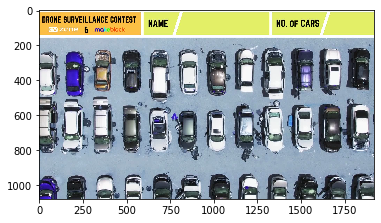

In [18]:
import matplotlib.pyplot as plt
plt.imshow(img)